In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load, assign and filter dataset input to less than 24 hour

In [ ]:
# Assign dataset names
list_of_names = ['pt_icu_outcome', 'labs_hourly', 'gcs_hourly', 'vitals_hourly', 'patients', 
                 'output_hourly', 'pt_weight', 'vasopressors']

# Create an empty dataframe list
df_list = []

# Append dataset into the list
for i in range(len(list_of_names)):
    temp_df = pd.read_csv(list_of_names[i]+".csv")
    df_list.append(temp_df)

# Filter patients: age >=18, length of stay (los) >=1
pt_icu_outcome = df_list[0][(df_list[0]['age_years'] >= 18) & (df_list[0]['los'] >= 1)]
print(pt_icu_outcome.shape)

# raw data of pt_icu_outcome is df_list[0] with 61533 rows × 17 columns
# After filtering data, there are 45254 rows × 17 columns

# Filter labs, gcs, vitals results <= 24hr
labs_hourly = df_list[1][df_list[1]['hr'] <= 24]
gcs_hourly = df_list[2][df_list[2]['hr'] <= 24]
vitals_hourly = df_list[3][df_list[3]['hr'] <= 24]

# assign patients dataset
patients = df_list[4]

# assign fluid output dataset (less than 24 hr)
output_hourly = df_list[5][df_list[5]['hr'] <= 24]

# assign patient weight
pt_weight = df_list[6]

# assign vasopressors
vasopressors = df_list[7]

# labs_hourly: From 928195 rows × 22 columns to 375504 rows (reduce 552691)
# gcs_hourly: From 1515342 rows × 7 columns to 412243 rows (reduce 1103099)
# vitals_hourly: From 7292362 rows × 11 columns to 1356845 rows (reduce 5935517)
#output_hourly: 775814 rows 3 columns

### Data preprocessing
- Grouped by `icustay_id` for each dataset then merge using this column
- Merge 4 dataset using inner join method

### Steps to process pt_icu_outcome
- Index the number of icustay per patient and filter out the last icustay (the largest index)
- Limit the ttd_days to 365 days only
- Create 4 more columns 48h, 72h, 3m, 6m, 1y to encode if the patient is dead within those time points
- `expire_flag` will be everything within a year from icu admission
- Train model using `expire_flag` then test each of those 4 cohorts to see how accurate we can predict

In [72]:
# pt_icu_outcome: drop everthing but the 4 columns as these are the most important features for ICU mortality prediction
pt_filter = pt_icu_outcome[['subject_id','icustay_id','age_years','los','expire_flag','ttd_days']]
# Has a duplicate of icustay_id 229922, subject_id 5246
# Remove duplicate and save under the same name
pt_filter = pt_filter.drop_duplicates()

# Checking the number of patients vs icustay
pt_icu_outcome['icustay_id'].nunique() 
# subject_id 33561, icustay_id 45253 -> patient can be admitted to multiple ICU
# counting the average of icustay per subject_id
pt_filter.groupby('subject_id')['icustay_id'].count().mean() #1.3 stay per patient

# Indexing the number of icustay using cumcount() function
pt_filter['icu_count_idx'] = pt_filter.groupby('subject_id').cumcount() + 1

# Fill 'ttd_days' with a -1 for NaN (alive records)
pt_filter.fillna({'ttd_days': -1}, inplace=True)
# Filter records with ttd_days <=365 days
pt_filter = pt_filter[pt_filter['ttd_days'] <= 365] #37767 records

# Limiting to one icustay per subject_id and choose the last icustay (the largest icu_count_idx)
# Find the index of the row with the largest `icu_count_idx` for each `subject_id`
last_icustay_indices = pt_filter.groupby('subject_id')['icu_count_idx'].idxmax()
# Filter the DataFrame to only include these rows
pt_filter = pt_filter.loc[last_icustay_indices] # 29453 records both icu and subject_id

# Adding 4 cols: expire_48h, expire_72h, expire_3m, expire_6m, expire_flag (1y = 9773)
pt_filter['expire_48h'] = np.where((pt_filter['ttd_days'] <= 2) & (pt_filter['expire_flag'] == 1), 1, 0) #1670 records
pt_filter['expire_1w'] = np.where((pt_filter['ttd_days'] <= 7) & (pt_filter['expire_flag'] == 1), 1, 0) #2080
pt_filter['expire_3m'] = np.where((pt_filter['ttd_days'] <= 90) & (pt_filter['expire_flag'] == 1), 1, 0) #7546
pt_filter['expire_6m'] = np.where((pt_filter['ttd_days'] <= 180) & (pt_filter['expire_flag'] == 1), 1, 0) #8634

# Calculate the mean of 'ttd_days'
mean_ttd_days = pt_filter.loc[pt_filter['expire_6m'] == 1, 'ttd_days'].mean()
print("Mean of ttd_days where expire_6m = 1:", mean_ttd_days)
# Mean of ttd_days where expire_flag = 1: 59.564412155939834
# Mean of ttd_days where expire_48h = 1: 1.0017964071856287
# Mean of ttd_days where expire_72h = 1: 1.395673076923077
# Mean of ttd_days where expire_3m = 1: 18.272197190564537
# Mean of ttd_days where expire_6m = 1: 32.514709288858

# patients: drop everything except subject_id gender
patients = patients[['subject_id', 'gender']]

# Merge these 2 dataset based on subject_id
pt_filter = pt_filter.merge(patients, on='subject_id', how='left')

pt_filter.info()

Mean of ttd_days where expire_6m = 1: 32.514709288858
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29453 entries, 0 to 29452
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subject_id     29453 non-null  int64  
 1   icustay_id     29453 non-null  int64  
 2   age_years      29453 non-null  float64
 3   los            29453 non-null  float64
 4   expire_flag    29453 non-null  int64  
 5   ttd_days       29453 non-null  float64
 6   icu_count_idx  29453 non-null  int64  
 7   expire_48h     29453 non-null  int64  
 8   expire_1w      29453 non-null  int64  
 9   expire_3m      29453 non-null  int64  
 10  expire_6m      29453 non-null  int64  
 11  gender         29453 non-null  object 
dtypes: float64(3), int64(8), object(1)
memory usage: 2.7+ MB


### Steps to process labs_hourly, vitals_hourly, gcs_hourly, pt_weight and output_hourly
- Exclude columns with missing data > 75%
- Only include values within 10th-90th percentile
- Group by icustay_id using the mean when condensing them

In [4]:
# Setting outlier percentile capping
low_cap = 0.1
high_cap = 0.90

In [ ]:
# pt_weight outlier remove
weight_filter = pt_weight[['icustay_id', 'avg_weight_naive']]
# Initialize 'w_outlier' with 0, assuming no outliers initially
# weight_filter['w_outlier'] = None


Q1 = weight_filter['avg_weight_naive'].quantile(low_cap)
Q3 = weight_filter['avg_weight_naive'].quantile(high_cap)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
weight_filter['w_outlier'] = np.where(
    ((weight_filter['avg_weight_naive'] < lower_whisker) | (weight_filter['avg_weight_naive'] > upper_whisker)),
    1,  # Mark as outlier
    0  # Retain existing value if condition is not met
)
clean_weight = weight_filter[(weight_filter['w_outlier'] == 0)]
clean_weight = clean_weight.drop('w_outlier', axis=1)

print(clean_weight.shape)
# output_hourly outlier remove
# Initialize 'w_outlier' with 0, assuming no outliers initially
# output_hourly['u_outlier'] = None

Q1 = output_hourly['urineoutput'].quantile(low_cap)
Q3 = output_hourly['urineoutput'].quantile(high_cap)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR
output_hourly['u_outlier'] = np.where(
    (output_hourly['urineoutput'] < lower_whisker) | (output_hourly['urineoutput'] > upper_whisker),
    1,  # Mark as outlier
    0
)
clean_urine = output_hourly[(output_hourly['u_outlier'] == 0)]
clean_urine = clean_urine.drop('u_outlier', axis=1)
print(clean_urine.shape)
# Checking missing data in pt_weight
weight_missing = clean_weight.isnull().mean() * 100
weight_missing

# Get the mean of each column according to the icustay_id
clean_weight = clean_weight.groupby('icustay_id', as_index=False).mean()
# Remove records with NaNs

# There are 54401 records

# Create a table name urine_output based on output_hourly dataset
urine_output = (
    clean_urine
    .groupby("icustay_id")
    .agg(
        total_urineoutput=("urineoutput", "sum"),  # Sum urineoutput for each icustay_id
        max_hr=("hr", "max")                      # Find the max hour for each icustay_id
    )
    .reset_index()
)

# Merget these above 2 datasets
df_urine_weight = clean_weight.merge(urine_output, on="icustay_id", how="inner")
df_urine_weight["urine_ml_kg_hr"] = df_urine_weight["total_urineoutput"]/ (df_urine_weight["avg_weight_naive"] * df_urine_weight["max_hr"])
df_urine_weight = df_urine_weight.drop(columns=['max_hr', 'total_urineoutput'])
print(df_urine_weight.shape)

# There are 53283 records

In [6]:
# Remove columns with > 75% missing data in vitals_hourly
vital_missing_percent = vitals_hourly.isnull().mean() * 100
filter_vitals_hourly = vitals_hourly.loc[:, vital_missing_percent <= 75]
filter_vitals_hourly = filter_vitals_hourly.drop('hr', axis=1)
filter_vitals_hourly.nunique()

# Create a list of column names
v_cols = filter_vitals_hourly.columns.to_list()
v_cols = v_cols[1:]

# Initialize 'v_outlier' with 0, assuming no outliers initially
filter_vitals_hourly['v_outlier'] = 0

for index, col in enumerate(v_cols, start=1):
    Q1 = filter_vitals_hourly[col].quantile(low_cap)
    Q3 = filter_vitals_hourly[col].quantile(high_cap)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    filter_vitals_hourly['v_outlier'] = np.where(
        (filter_vitals_hourly['v_outlier'] == 0) &  # Only update if it's still 0 (not previously marked as an outlier)
        ((filter_vitals_hourly[col] < lower_whisker) | (filter_vitals_hourly[col] > upper_whisker)),
        index,  # Assign the column index as the outlier value
        filter_vitals_hourly['v_outlier']  # Keep the previous value if no outlier
    )
clean_vitals = filter_vitals_hourly[(filter_vitals_hourly['v_outlier'] == 0)]

In [7]:
# Remove columns with > 75% missing data in labs_hourly
lab_missing_percent = labs_hourly.isnull().mean() * 100
filter_labs_hourly = labs_hourly.loc[:, lab_missing_percent <= 75]
filter_labs_hourly = filter_labs_hourly.drop(columns='hr', axis=1)
filter_labs_hourly.nunique()

# Create a list of column names
l_cols = filter_labs_hourly.columns.to_list()
l_cols = l_cols[1:]

# Initialize 'v_outlier' with 0, assuming no outliers initially
filter_labs_hourly['l_outlier'] = 0

for index, col in enumerate(l_cols, start=1):
    Q1 = filter_labs_hourly[col].quantile(low_cap)
    Q3 = filter_labs_hourly[col].quantile(high_cap)
    IQR = Q3 - Q1
    lower_whisker = Q1 - 1.5 * IQR
    upper_whisker = Q3 + 1.5 * IQR
    filter_labs_hourly['l_outlier'] = np.where(
        (filter_labs_hourly['l_outlier'] == 0) &  # Only update if it's still 0 (not previously marked as an outlier)
        ((filter_labs_hourly[col] < lower_whisker) | (filter_labs_hourly[col] > upper_whisker)),
        index,  # Assign the column index as the outlier value
        filter_labs_hourly['l_outlier']  # Keep the previous value if no outlier
    )
clean_labs = filter_labs_hourly[(filter_labs_hourly['l_outlier'] == 0)]

In [8]:
# Generate filter dataset of lab, vitals and gcs
# Get the mean of each column according to the icustay_id
labs_filter = clean_labs.groupby('icustay_id', as_index=False).mean()
# Check the percentage of missing values again after grouping
l_miss_percent = labs_filter.isnull().mean()*100

# Drop columns with > 20% missing value
labs_filter = labs_filter.loc[:, l_miss_percent <= 20]
labs_filter = labs_filter.drop('l_outlier', axis=1)
labs_filter.columns.to_list()

# Vitals
vitals_filter = clean_vitals.groupby('icustay_id', as_index=False).mean()
vitals_filter = vitals_filter.drop('v_outlier', axis=1)
vitals_filter.isnull().mean()*100

# GCS
# Check gcs_hourly columns with > 75% missing data
gcs_hourly.isnull().mean() * 100 # all good, low missing percent
# as gcs is categorised by number -> no need to process to remove outlier

gcs_filter = gcs_hourly.groupby('icustay_id', as_index=False).mean()
gcs_filter = gcs_filter.drop('hr', axis=1)
gcs_filter.isnull().mean()*100

# Check the shape of the filtered datasets
print(vitals_filter.shape)
print(labs_filter.shape)
print(gcs_filter.shape)

(60844, 8)
(59872, 11)
(52221, 6)


# EDA
- Examine the percentage of missing data in the merged dataset
- Examine outliers
- Examine correlation matrix
- Checking class balance to identify any imbalance: In this dataset the `expired_flag` 0 and 1 are imbalanced
- Checking histogram for the distribution of each feature in regards to the 2 classes
- Impute the missing data with mean method.

In [ ]:
# One hot encoding for gender
from sklearn.preprocessing import OneHotEncoder

# Merge dataframes on 'icustay_id'
merged_df = pt_filter.merge(labs_filter, on='icustay_id', how='inner') \
                     .merge(gcs_filter, on='icustay_id', how='inner') \
                     .merge(vitals_filter, on='icustay_id', how='inner') \
                     .merge(df_urine_weight, on='icustay_id', how='inner') # this \ is a continuation character
# choose inner join to reduce the missing rates and focus on the id that has most data

# add vasopressors flag into merge_df
# Create a set of icustay_id from vasopressors for faster lookup
vaso_ids = set(vasopressors['icustay_id'])

# Add a new column 'vaso_administered' to final_df
merged_df['vaso_administered'] = merged_df['icustay_id'].apply(lambda x: 1 if x in vaso_ids else 0)

# Display the updated DataFrame
merged_df.info()

# Replace inf and -inf with NaN (as urine_ml_kg_hr can be inf due to 0 division)
merged_df.replace([np.inf, -np.inf], np.nan, inplace=True)

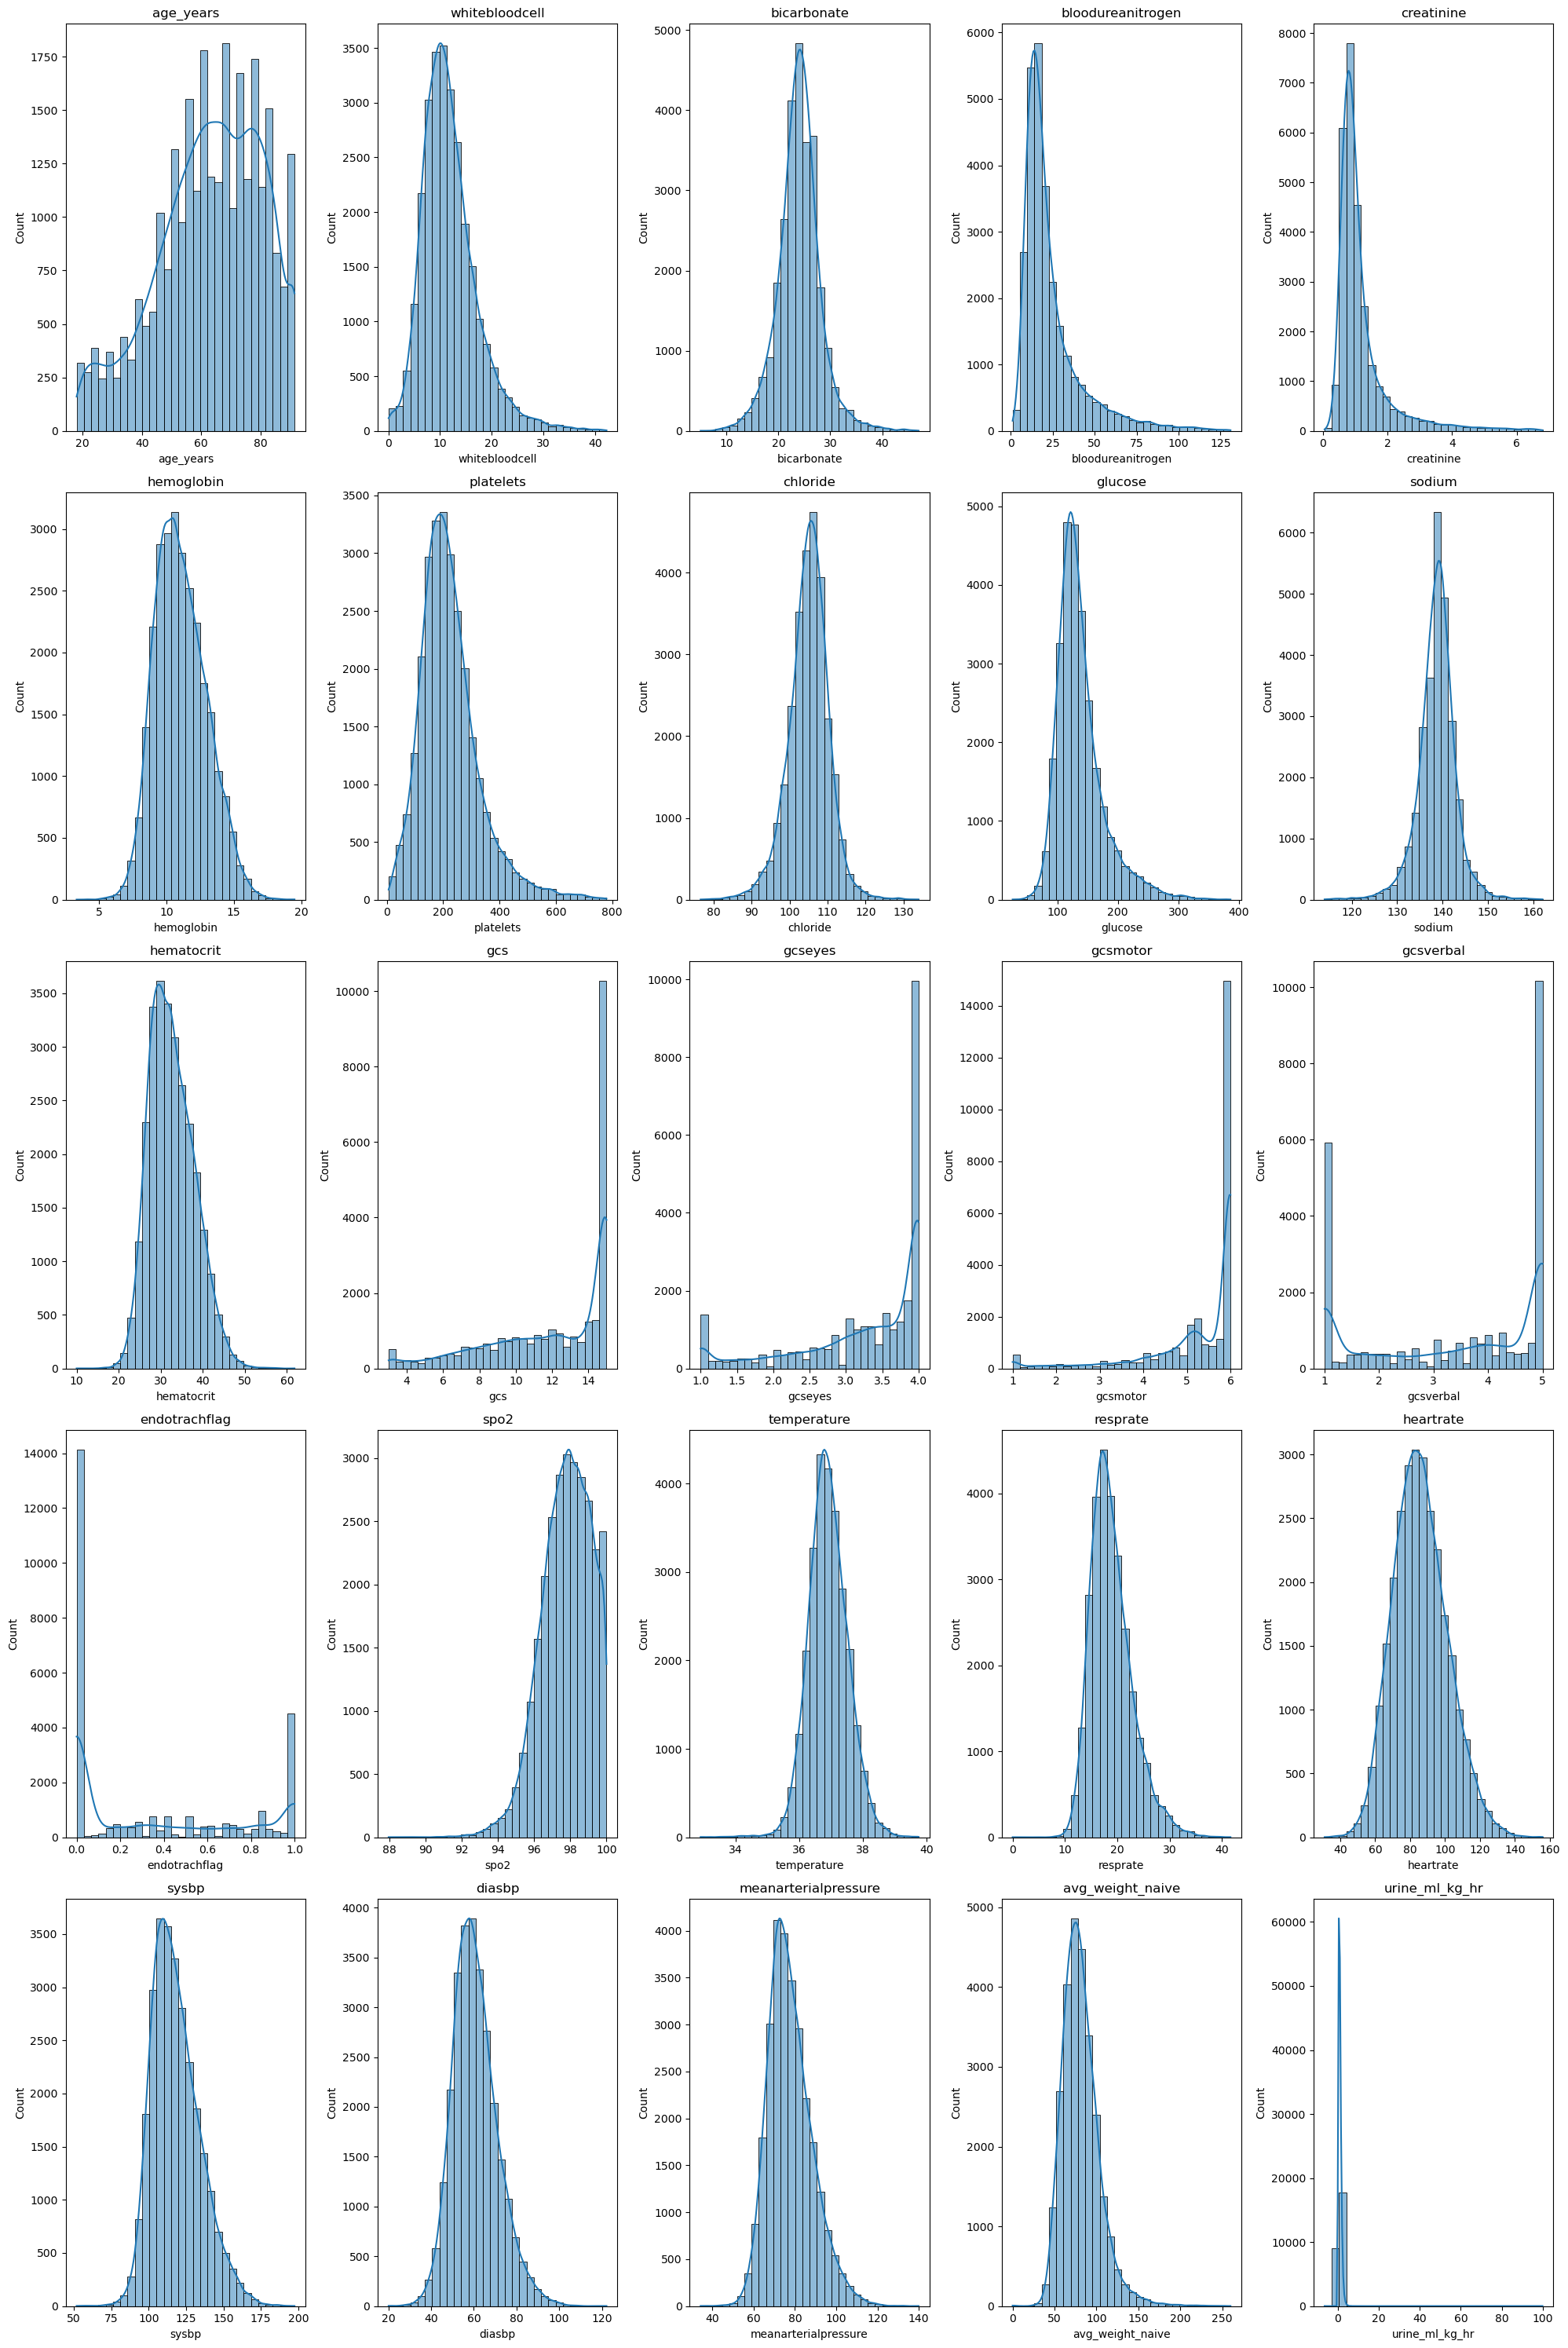

In [130]:
# Boxplot of float64 type variables
merged_plot_df = merged_df.select_dtypes(include=['float64'])
merged_plot_df = merged_plot_df.drop(columns=['ttd_days','los'], axis=1)

fig, axes = plt.subplots(ncols=5, nrows=5, figsize = (20,30))
for i, ax in enumerate(axes.flat):
    if i < len(merged_plot_df.columns):
        column_name = merged_plot_df.columns[i] # retrieve the name of the column at index position i
        sns.histplot(x=column_name, data=merged_plot_df, ax=ax, bins=30, kde=True)
        ax.set_title(column_name)
plt.tight_layout()

In [131]:
# Converting wide to long table for histogram visualisation and add expire_flag
merged_plot_df['expire_flag'] = merged_df['expire_flag']

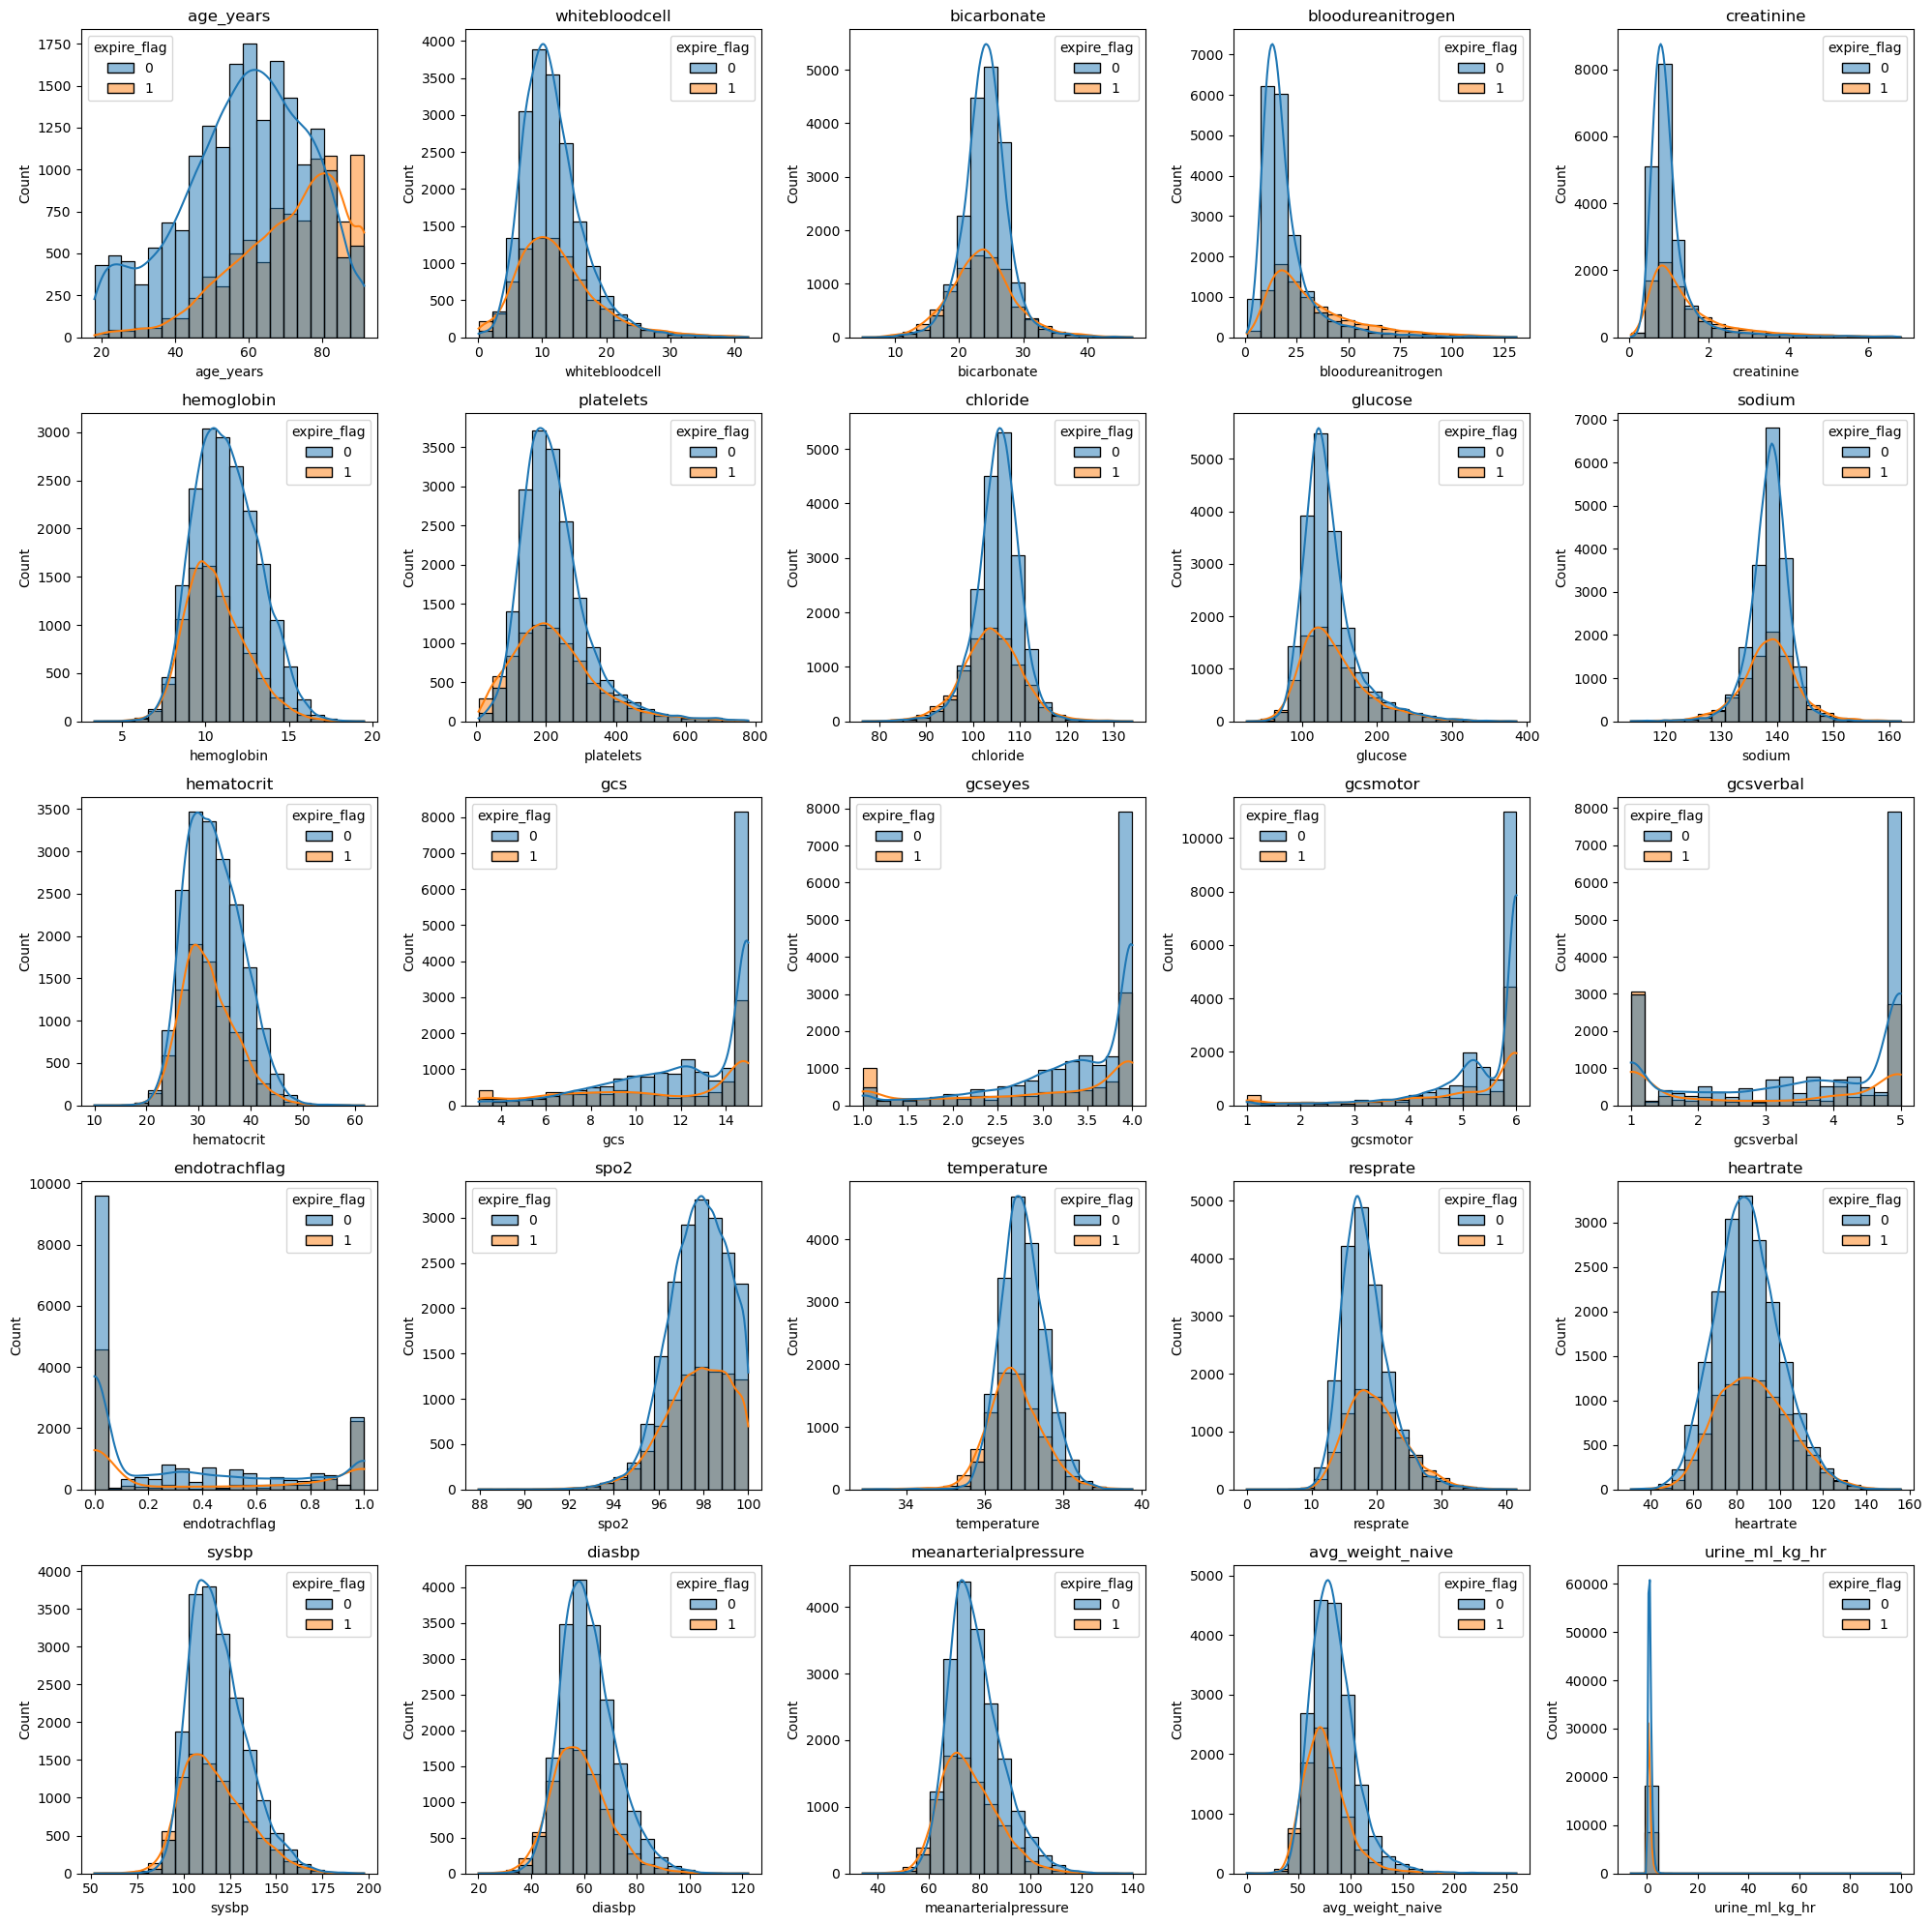

In [132]:
# Create a grid of subplots
fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(20, 20))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate through the columns and plot overlaid histograms
for i, ax in enumerate(axes):
    if i < len(merged_plot_df.columns):
        column_name = merged_plot_df.columns[i]  # Retrieve the column name
        sns.histplot(
            data=merged_plot_df,
            x=column_name,
            hue=merged_plot_df['expire_flag'],  # Group by 'expire_flag'
            ax=ax,
            bins=20,
            alpha=0.5,
            kde=True
            #palette="Set1"  # Optional: Set color palette
        )
        ax.set_title(column_name)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

# Adjust layout
plt.tight_layout()
plt.show()


In [70]:
# Examine the mean of the merged_df dataset
summary_df = merged_df.select_dtypes(include = ['int64', 'float64'])
# Compute each statistic and store in a dictionary
summary_stats = {
    'Mean': summary_df.mean(),
    'Median': summary_df.median(),
    'Range': summary_df.max() - summary_df.min(),  # Range as max - min
    'Standard Deviation': summary_df.std(),
    'Variance': summary_df.var()
}

# Convert the dictionary to a DataFrame
summary_stats = pd.DataFrame(summary_stats)

# Display the summary DataFrame
summary_stats.round(2)

,Mean,Median,Range,Standard Deviation,Variance
subject_id,40434.26,29879.00,99996.00,29671.78,8.804148e+08
icustay_id,250001.80,250119.50,99996.00,28903.08,8.353878e+08
age_years,62.99,65.00,73.40,17.50,3.064100e+02
los,4.51,2.44,99.12,5.99,3.590000e+01
expire_flag,0.32,0.00,1.00,0.47,2.200000e-01
ttd_days,18.56,-1.00,366.00,57.16,3.266770e+03
icu_count_idx,1.31,1.00,31.00,0.91,8.200000e-01
expire_48h,0.05,0.00,1.00,0.23,5.000000e-02
expire_72h,0.07,0.00,1.00,0.25,6.000000e-02
expire_3m,0.25,0.00,1.00,0.43,1.900000e-01


In [ ]:
table = merged_df[['ttd_days','los','expire_48h','expire_1w','expire_3m','expire_6m','expire_flag']]
table = table[table['ttd_days']>=0]
table[table['ttd_days']<=365].mean()

## Class balance
- Check class balance in `expire_flag` -> imbalance dataset

/var/folders/24/fyw_npvd5tvg3rr3h5q73nqr0000gn/T/ipykernel_750/667926984.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=merged_df, x ='expire_flag', palette="Set2", legend=False)


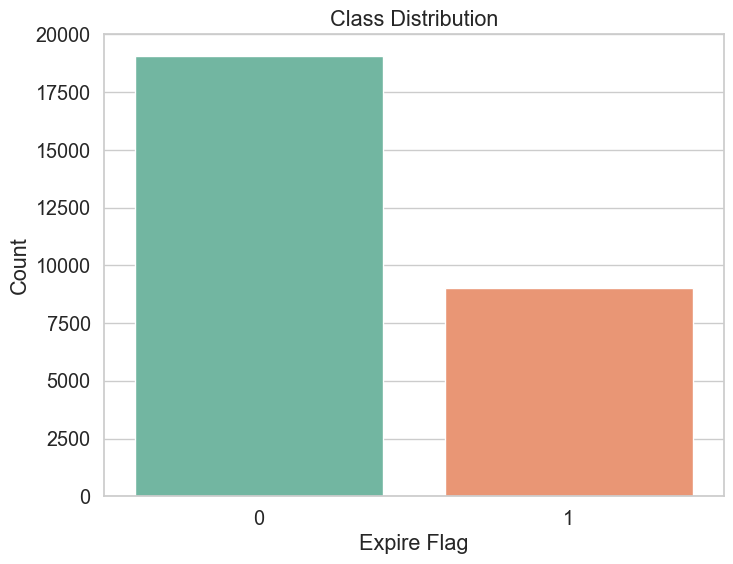

In [151]:
# Plotting the count of each class in 'expire_flag'
sns.set(style="whitegrid", font_scale=1.3)
plt.figure(figsize=(8, 6))
sns.countplot(data=merged_df, x ='expire_flag', palette="Set2", legend=False)

# Adding labels and title
plt.xlabel("Expire Flag")
plt.ylabel("Count")
plt.title("Class Distribution")
plt.show()

In [ ]:
# Calculate counts and percentages for each class in 'icu_expire_flag'
count_values = merged_df['expire_flag'].value_counts()
percentage_values = merged_df['expire_flag'].value_counts(normalize=True) * 100

# Combine into a single DataFrame
summary_df = pd.DataFrame({
    'Count': count_values,
    'Percentage (%)': percentage_values.round(2)  # Round percentages to 2 decimal places
})

# Display the table
print(summary_df)


In [ ]:
# Columns of interest
expire_cols = ['expire_48h', 'expire_1w', 'expire_3m', 'expire_6m', 'expire_flag']

# Create an empty list to store the results
summary_data = []

for col in expire_cols:
    survival_count = (merged_df[col] == 0).sum()  # Count where value is 0 (survived)
    death_count = (merged_df[col] == 1).sum()     # Count where value is 1 (expired)
    mortality_percent = (death_count / (survival_count + death_count)) * 100  # Mortality rate
    avg_ttd = merged_df.loc[(merged_df[col] == 1) & (merged_df['ttd_days'] >= 0), 'ttd_days'].mean()

    # Append results to summary data
    summary_data.append({
        'Category': col,
        'Survival_Count': survival_count,
        'Death_Count': death_count,
        'Mortality_Percent': mortality_percent,
        'Average_ttd': avg_ttd
    })

# Convert the summary data into a DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary DataFrame
summary_df

In [ ]:
# Drop columns in merged_df: subject_id, icustay_id, los, ttd_days, icu_count_idx, expire_48h - 6m
final_df = merged_df.drop(columns=['subject_id', 'icustay_id','los', 'ttd_days', 'icu_count_idx'])
final_df

### One Hot Encoding for Gender

In [92]:
# One hot encoding for gender
from sklearn.preprocessing import OneHotEncoder

# Define the categorical column
categorical_columns = ['gender']  # Column to be one-hot encoded

# Initialize the encoder
encoder = OneHotEncoder(sparse_output=False, drop=None)  # Use `sparse=False` for older scikit-learn versions

# Apply one-hot encoding to the categorical column
one_hot_encoded = encoder.fit_transform(final_df[categorical_columns])

# Create a DataFrame for the one-hot encoded columns
# Column names are generated automatically by sklearn with get_feature_names_out
one_hot_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=final_df.index)

# Concatenate the one-hot encoded DataFrame with the original DataFrame
final_encoded_df = pd.concat([final_df, one_hot_df], axis=1)

# Drop the original categorical column(s)
final_encoded_df = final_encoded_df.drop(categorical_columns, axis=1)

## Imputation
- Imputation with mean or median and save in different dataset names: merged_df_mean_impute, merged_df_median_impute

In [93]:
from sklearn.impute import SimpleImputer

# Use mean to impute missing values
mean_imputer = SimpleImputer(strategy='mean')
df_mean_impute = mean_imputer.fit_transform(final_encoded_df)

#After using SimpleImputer, the result is a NumPy array

# Convert back to DataFrame and retain original column names
df_mean_impute = pd.DataFrame(df_mean_impute, columns=final_encoded_df.columns)

# Model development

In [13]:
# Import sklearn packages
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, RocCurveDisplay
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV

# Import xgboost package
from xgboost import XGBClassifier

# Import from imblearn package
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Import shap
import shap

### Create a function for confusion matrix display and model evaluation

In [14]:
# Confusion matrix
def plot_cm(train_cm, test_cm):
    # Plot confusion matrices
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(train_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Training Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')

    sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Test Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

# Create a function to run a full model evaluation process

def model_evaluation(model_name):
    # Use model to predict y outcome values:
    y_pred_train = model_name.predict(X_train)
    y_pred_test = model_name.predict(X_test)

    # Evaluate the model: Classification report, ROC-AUC, confusion matrix
    print("Training set classification report:\n", classification_report(y_train, y_pred_train))
    print("Testing set classification report:\n", classification_report(y_test, y_pred_test))

    # ROC-AUC curve
    # Predict probabilities (y_score) for the positive class. Calculate ROC curve
    y_probs_train = model_name.predict_proba(X_train)[:, 1]  # Get probabilities for the positive class
    y_probs_test = model_name.predict_proba(X_test)[:, 1]
    # Calculate ROC curve
    print("ROC of the training set: ", roc_auc_score(y_train, y_probs_train))
    print("ROC of the testing set: ", roc_auc_score(y_test, y_probs_test))

    # Create ROC Curve Display for the training set
    fig, axes = plt.subplots(1, 2, figsize=(12,5))
    display = RocCurveDisplay.from_predictions(
        y_train,        # True binary labels (0 and 1)
        y_probs_train,       # Predicted probabilities for class 1
        name="Train dead prediction",
        color="darkorange",
        plot_chance_level=True,
        ax=axes[0]
    )
    # ROC Curve for the testing set
    RocCurveDisplay.from_predictions(
        y_test,        # True binary labels for testing set
        y_probs_test,  # Predicted probabilities for testing set
        name="Testing dead prediction",
        color="darkorange",
        plot_chance_level=True,
        ax=axes[1]
    )
    # Set labels and title. No need to set the label for each axis because the RocCurveDisplay has it already.
    axes[0].set_title("Train set: ROC curve expire_flag = 1 predicted probability")
    axes[1].set_title("Test set: ROC curve expire_flag = 1 predicted probability")

    # Show the plot
    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    plot_cm(cm_train, cm_test)

In [133]:
df_1y = df_mean_impute.drop(columns=['expire_48h','expire_1w','expire_3m','expire_6m'], axis = 1)

### Prepare data for training and testing

In [134]:
# Use mean imputated data
X = df_1y.drop(columns=['expire_flag'])  # Features
y = df_1y['expire_flag']  # Target: 1 if patient expired (dead), 0 otherwise (alive)

In [174]:
# Split the data into train/test set (70/30)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)
# choose stratify=y to preserve the ratio between 0 and 1 expire_flag

### Logistic regression

In [182]:
# Step 1: Create a Pipeline to house the preprocessing steps: imputer, scaler, pca and model
pipeline = Pipeline([
    ('scaler', StandardScaler()),                         # Scaling to standardise features
    ('model', LogisticRegression())                       # Specify the model to access
])
print(pipeline)

Pipeline(steps=[('scaler', StandardScaler()), ('model', LogisticRegression())])


Training set classification report:
               precision    recall  f1-score   support

         0.0       0.81      0.90      0.85     13340
         1.0       0.71      0.55      0.62      6299

    accuracy                           0.78     19639
   macro avg       0.76      0.72      0.74     19639
weighted avg       0.78      0.78      0.78     19639

Testing set classification report:
               precision    recall  f1-score   support

         0.0       0.81      0.90      0.85      5717
         1.0       0.72      0.57      0.64      2700

    accuracy                           0.79      8417
   macro avg       0.77      0.73      0.74      8417
weighted avg       0.78      0.79      0.78      8417

ROC of the training set:  0.8392894400553336
ROC of the testing set:  0.8425001457640954


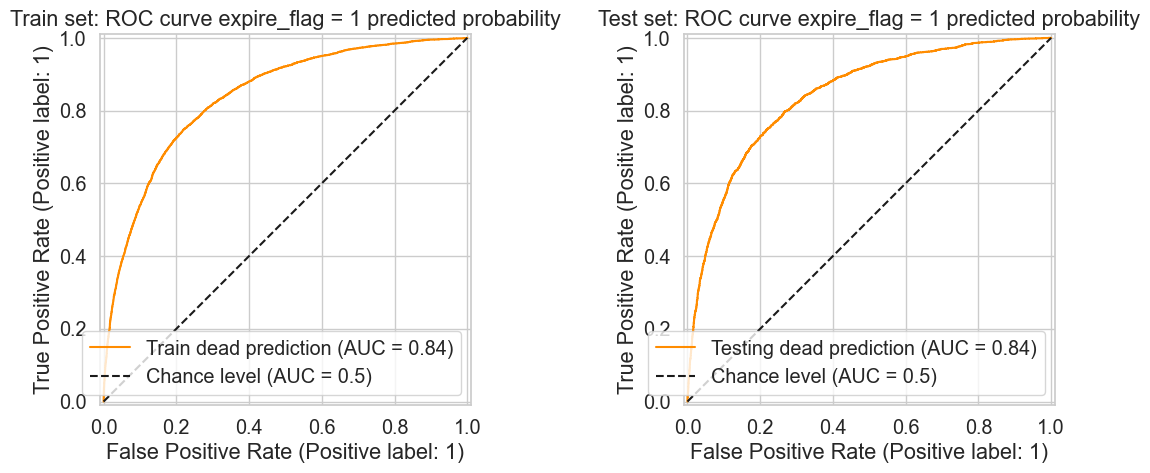

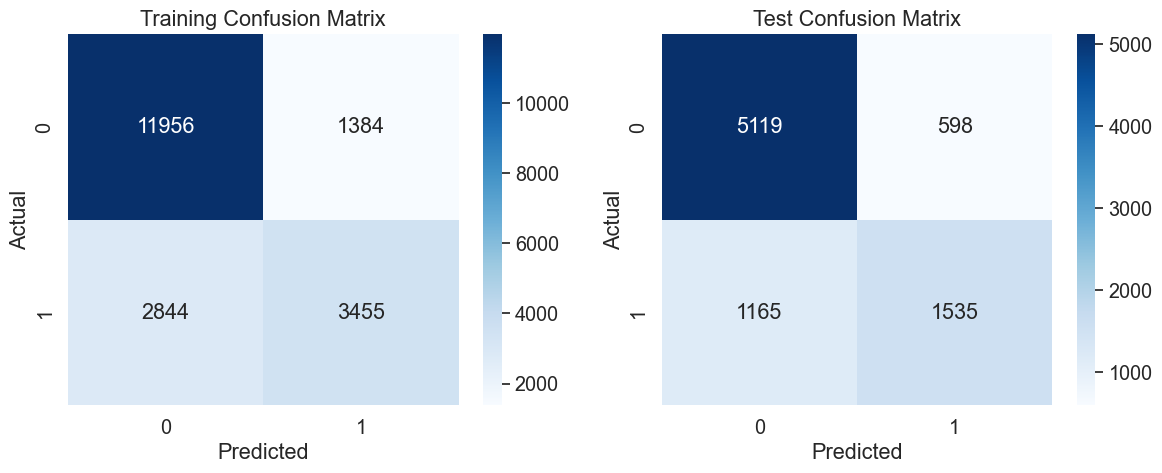

In [183]:
# Logistic regression model
model_lr = pipeline
model_lr.fit(X_train, y_train)
model_evaluation(model_lr)

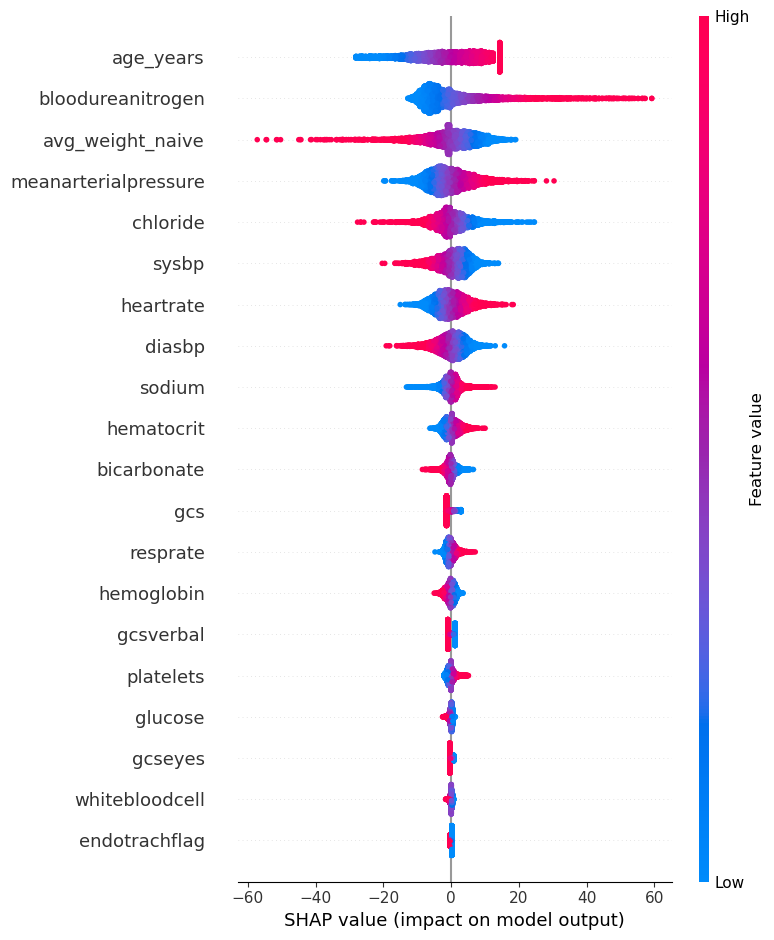

In [138]:
# Extract the Logistic Regression model from the pipeline
model_lr_shap = pipeline.named_steps['model']

# compute the SHAP values for the linear model
explainer_lr = shap.Explainer(model_lr_shap, X_train)
shap_values_lr = explainer_lr(X_test)

shap.summary_plot(shap_values_lr, X_test)

### Decision tree
- No need imputation and scaler
- Apply on the original dataset with NaNs and outliers
- This model results in an excellent ROC, accuracy and f1-score on the training set but quite poorly on the test set

Training set classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      6299
         1.0       1.00      1.00      1.00      6299

    accuracy                           1.00     12598
   macro avg       1.00      1.00      1.00     12598
weighted avg       1.00      1.00      1.00     12598

Testing set classification report:
               precision    recall  f1-score   support

         0.0       0.68      0.69      0.68      2700
         1.0       0.68      0.68      0.68      2700

    accuracy                           0.68      5400
   macro avg       0.68      0.68      0.68      5400
weighted avg       0.68      0.68      0.68      5400

ROC of the training set:  1.0
ROC of the testing set:  0.682962962962963


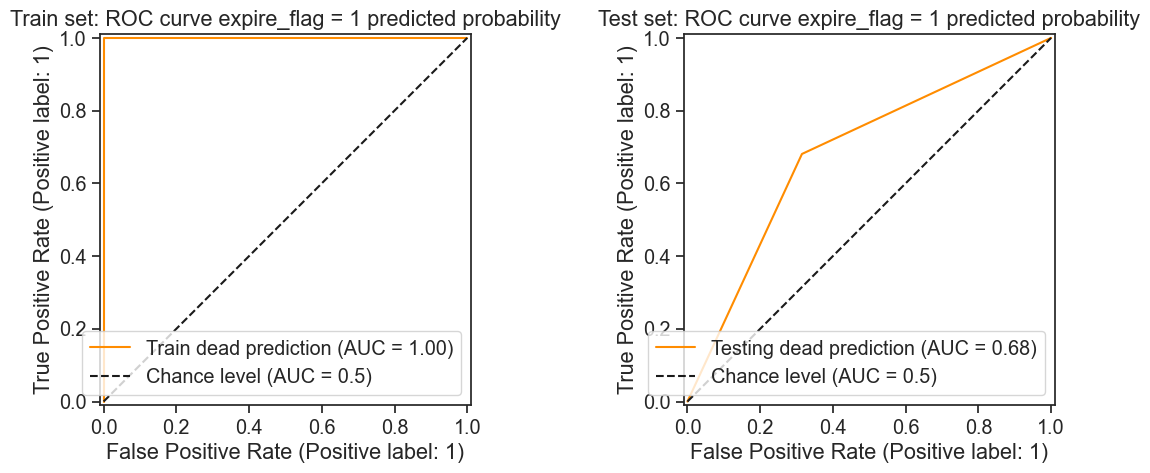

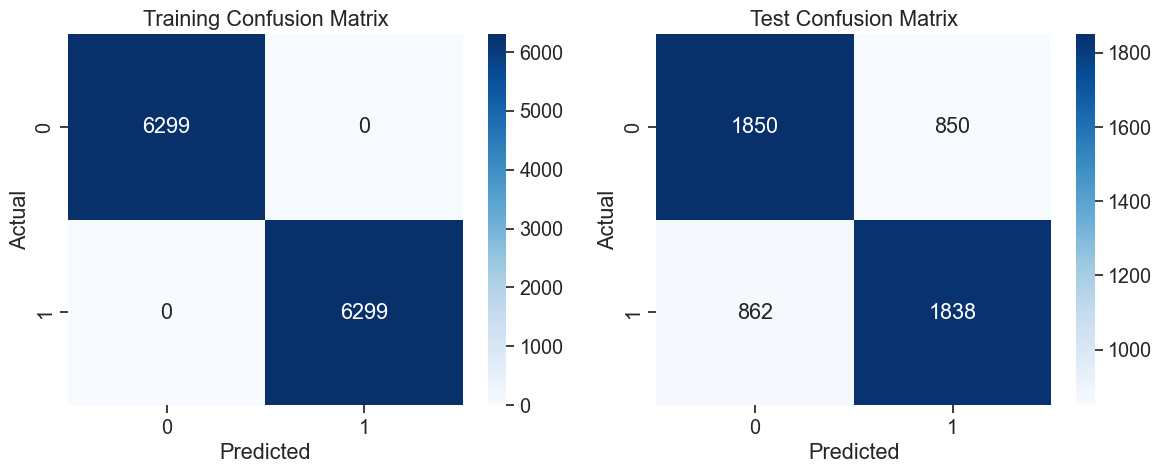

In [139]:
# Decision tree benchmark model
model_dt = DecisionTreeClassifier()
# Fit this model
model_dt.fit(X_train, y_train)
# Model evaluation
model_evaluation(model_dt)

### Random Forest

Training set classification report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     13340
         1.0       1.00      1.00      1.00      6299

    accuracy                           1.00     19639
   macro avg       1.00      1.00      1.00     19639
weighted avg       1.00      1.00      1.00     19639

Testing set classification report:
               precision    recall  f1-score   support

         0.0       0.83      0.89      0.86      5717
         1.0       0.73      0.63      0.67      2700

    accuracy                           0.81      8417
   macro avg       0.78      0.76      0.77      8417
weighted avg       0.80      0.81      0.80      8417

ROC of the training set:  1.0
ROC of the testing set:  0.865928063799325


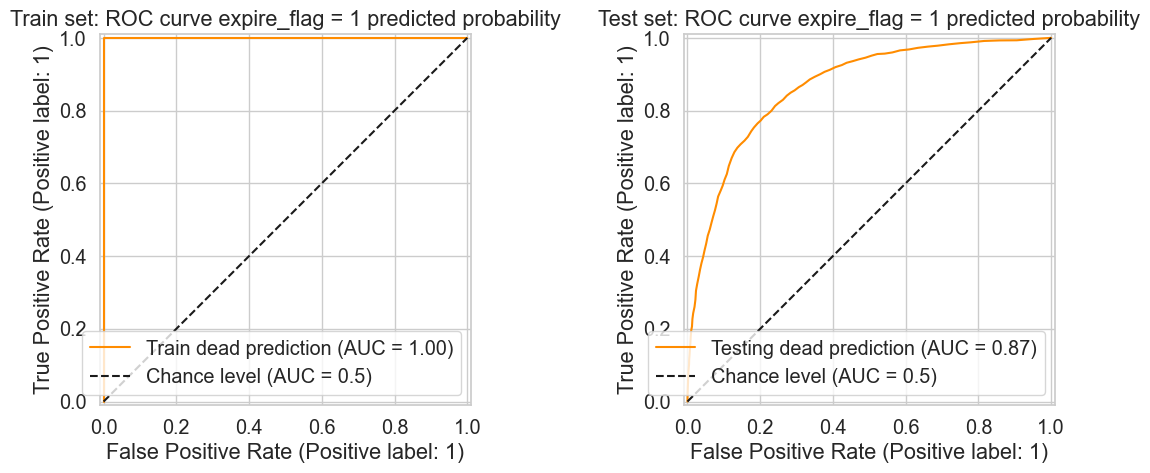

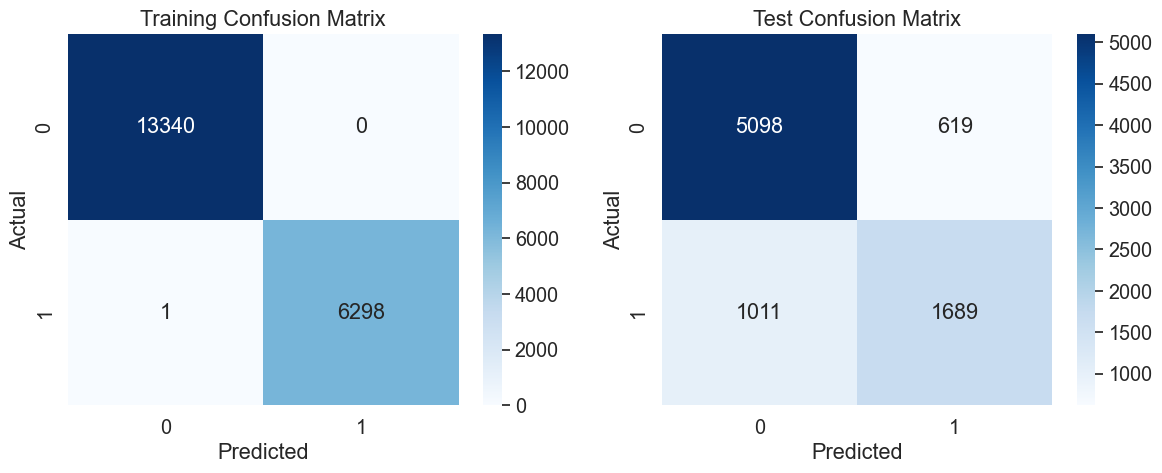

In [178]:
# Random Forest Benchmark model
model_rf = RandomForestClassifier()
# Fit model
model_rf.fit(X_train, y_train)
# Model evaluation
model_evaluation(model_rf)

/var/folders/24/fyw_npvd5tvg3rr3h5q73nqr0000gn/T/ipykernel_17573/3304985054.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=top_features, palette="viridis")


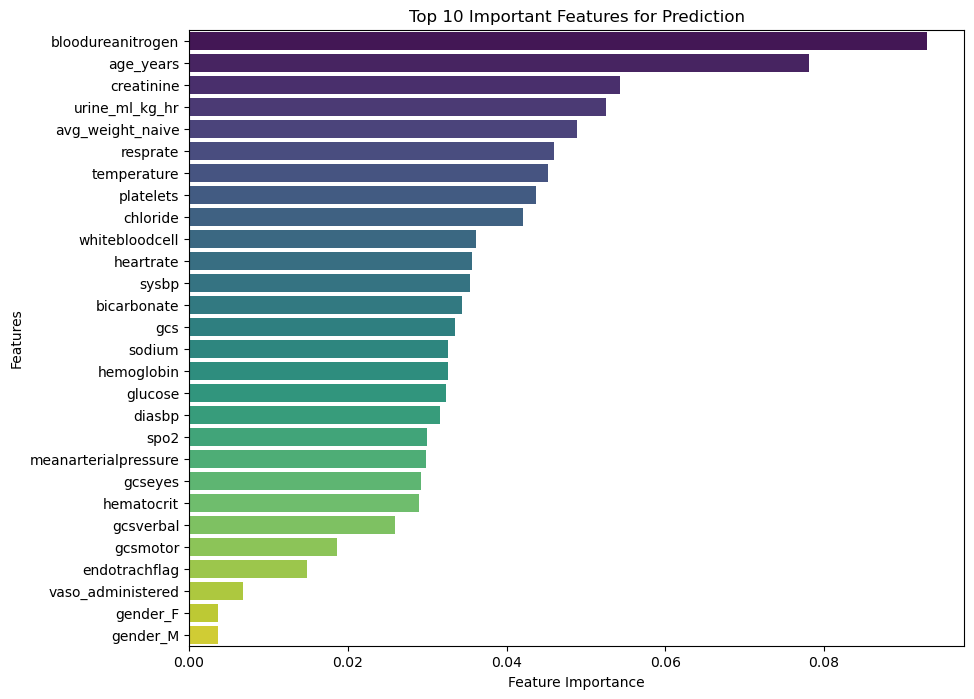

In [48]:
# Get feature importances
importances = model_rf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort by importance and select the top 10 features
top_features = feature_importance_df.sort_values(by='importance', ascending=False)

# Plot the top 10 features
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=top_features, palette="viridis")
plt.title("Top 10 Important Features for Prediction")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.show()

### Gradient boosting
- This model can improve the score well
- The training and testing set achieved similar scoring profile
- This takes longer

Training set classification report:
               precision    recall  f1-score   support

         0.0       0.84      0.91      0.88     13340
         1.0       0.78      0.64      0.70      6299

    accuracy                           0.83     19639
   macro avg       0.81      0.78      0.79     19639
weighted avg       0.82      0.83      0.82     19639

Testing set classification report:
               precision    recall  f1-score   support

         0.0       0.83      0.90      0.86      5717
         1.0       0.74      0.61      0.67      2700

    accuracy                           0.81      8417
   macro avg       0.79      0.76      0.77      8417
weighted avg       0.80      0.81      0.80      8417

ROC of the training set:  0.8908124680317406
ROC of the testing set:  0.8671673177462926


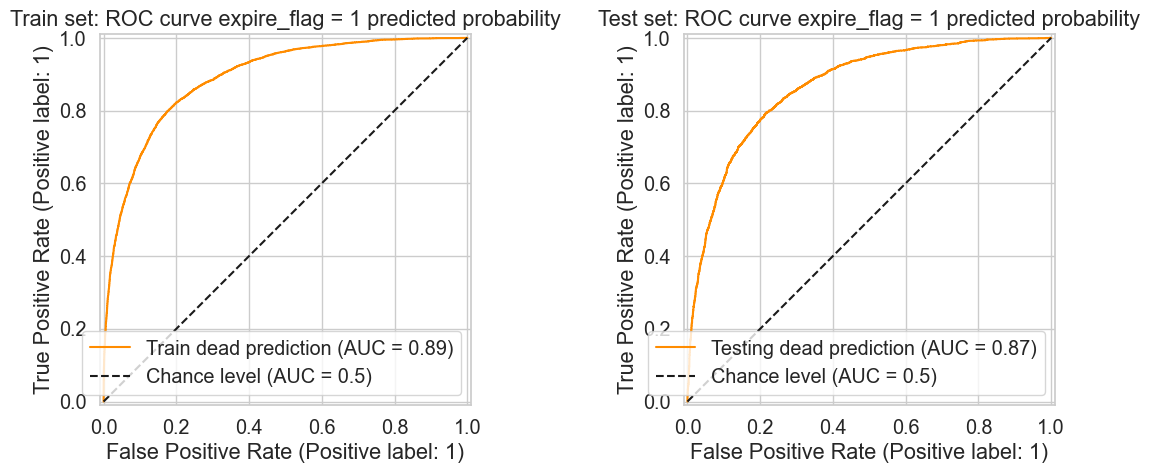

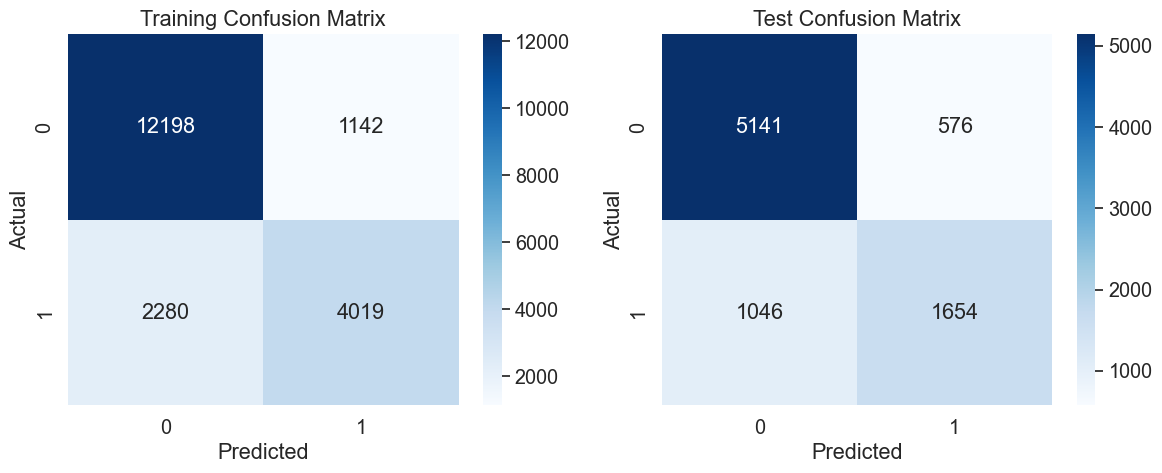

In [179]:
# Step 1: Benchmark model
model_gb = pipeline.set_params(model=GradientBoostingClassifier())

# Step 2: Fit the model into the training data as we want to get the parameter learned from this fitting process to apply to the train and test set
model_gb.fit(X_train, y_train)

# Model evaluation
model_evaluation(model_gb)

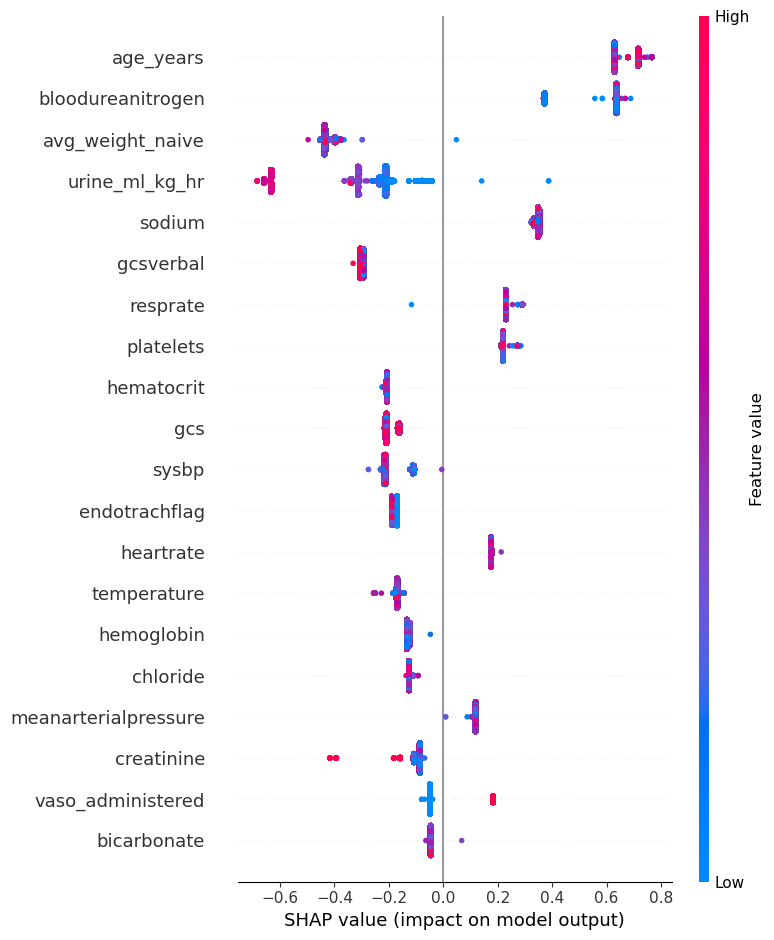

In [142]:
model_gb_shap = model_gb.named_steps['model']
explainer_gb = shap.Explainer(model_gb_shap)
shap_values_gb = explainer_gb.shap_values(X)
shap.summary_plot(shap_values_gb, X)

### Histogram-based Gradient Boosting Tree
- This model runs faster than normal GB and can handle NaN natively

Training set classification report:
               precision    recall  f1-score   support

         0.0       0.89      0.93      0.91     13340
         1.0       0.84      0.77      0.80      6299

    accuracy                           0.88     19639
   macro avg       0.87      0.85      0.86     19639
weighted avg       0.88      0.88      0.88     19639

Testing set classification report:
               precision    recall  f1-score   support

         0.0       0.85      0.88      0.86      5717
         1.0       0.72      0.66      0.69      2700

    accuracy                           0.81      8417
   macro avg       0.79      0.77      0.78      8417
weighted avg       0.81      0.81      0.81      8417

ROC of the training set:  0.9415049341498484
ROC of the testing set:  0.8727501473836965


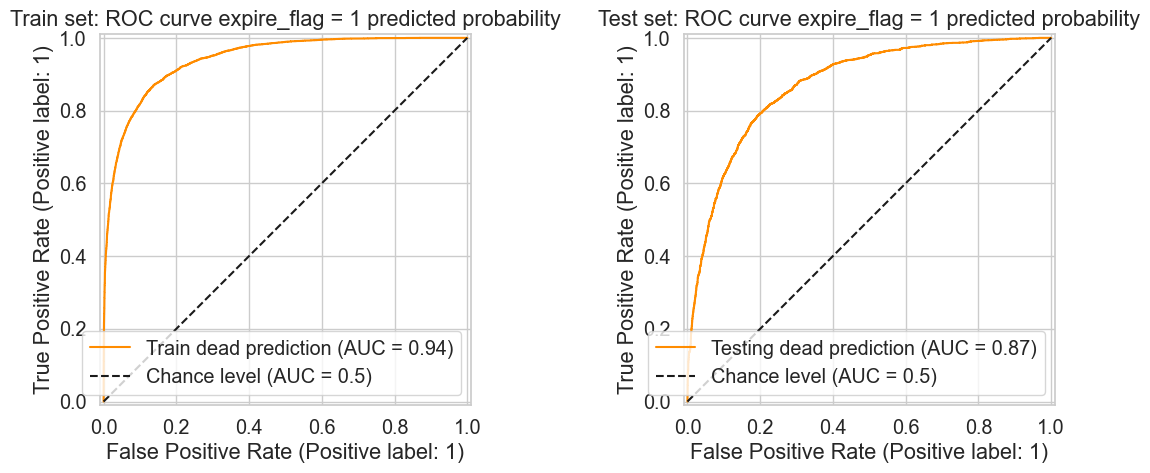

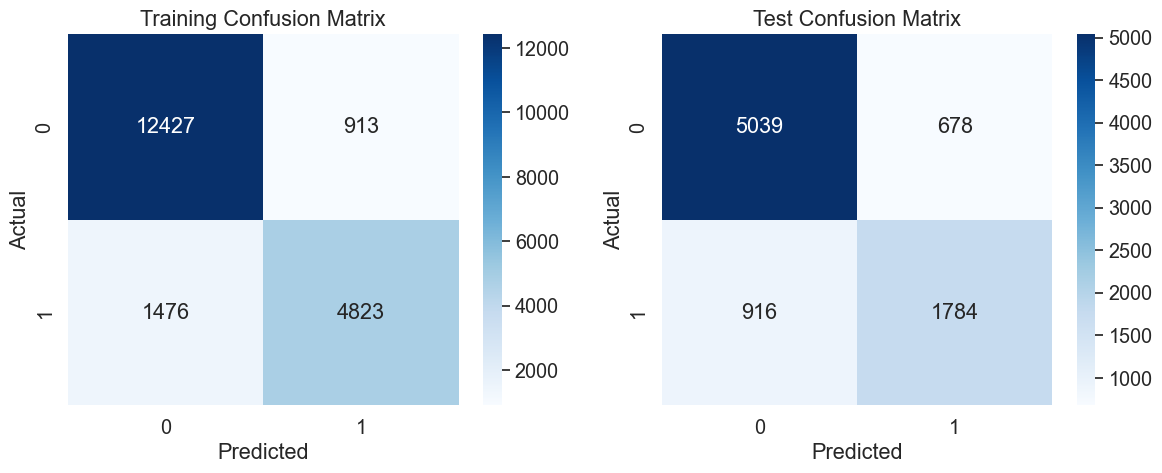

In [180]:
# Histogram Gradient Boosting
model_hgb = HistGradientBoostingClassifier()
model_hgb.fit(X_train, y_train)
model_evaluation(model_hgb)

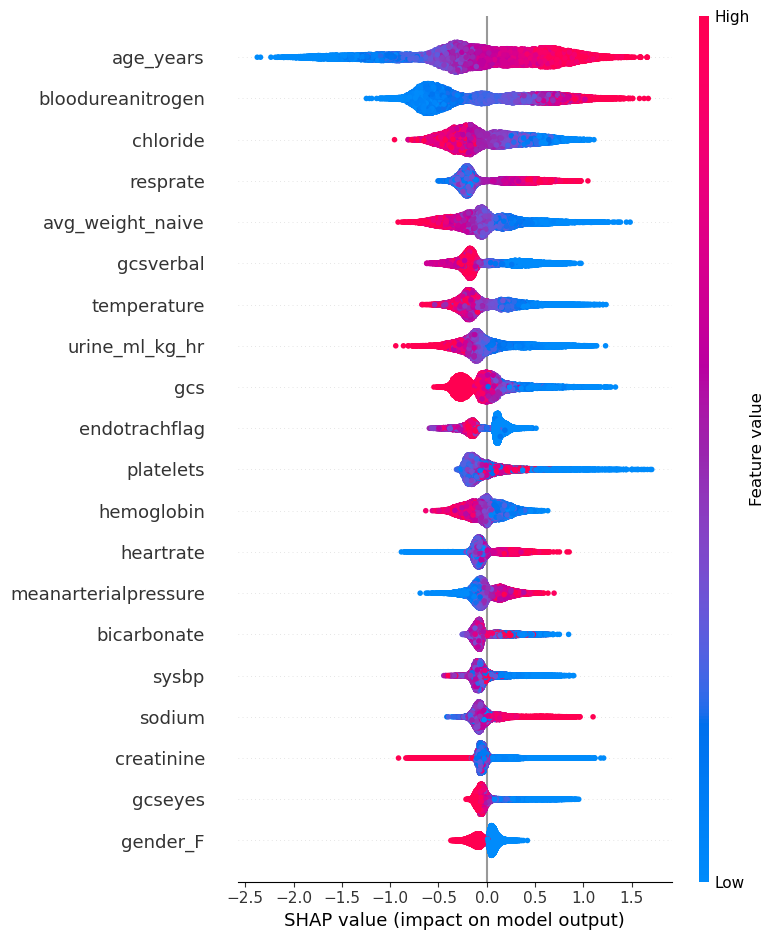

In [144]:
explainer_hgb = shap.TreeExplainer(model_hgb)
shap_values_hgb = explainer_hgb.shap_values(X)

shap.summary_plot(shap_values_hgb, X)

### XGBoost Model

/Users/hanhnguyen/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:24:45] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Training set classification report:
               precision    recall  f1-score   support

         0.0       0.96      0.99      0.97     13340
         1.0       0.97      0.91      0.94      6299

    accuracy                           0.96     19639
   macro avg       0.97      0.95      0.96     19639
weighted avg       0.96      0.96      0.96     19639

Testing set classification report:
               precision    recall  f1-score   support

         0.0       0.84      0.87      0.86      5717
         1.0       0.71      0.65      0.68      2700

    accuracy                           0.80      8417
   macro avg       0.77      0.76      0.77      8417
weighted avg       0.80      0.80      0.80      8417

ROC of the training set:  0.9913596384852502
ROC of the testing set:  0.8626549148413764


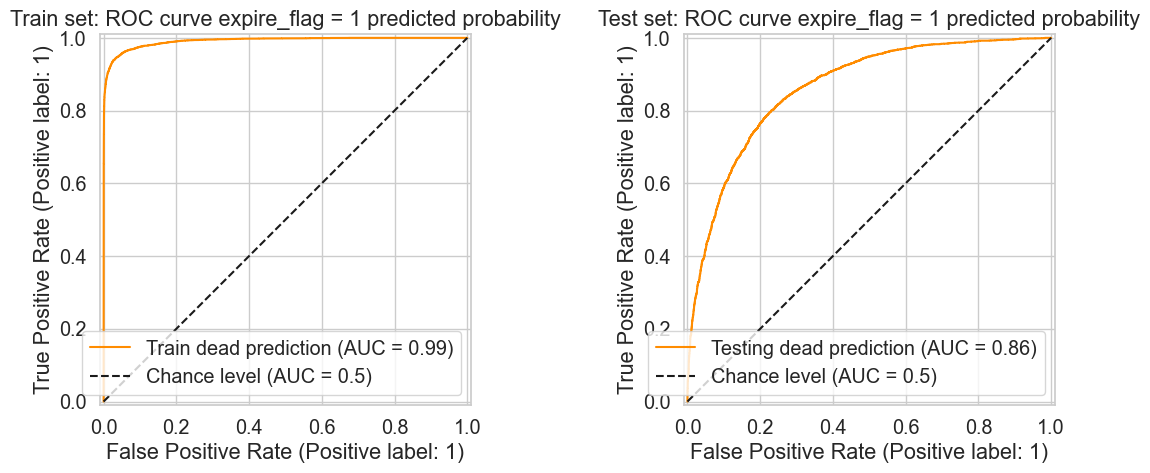

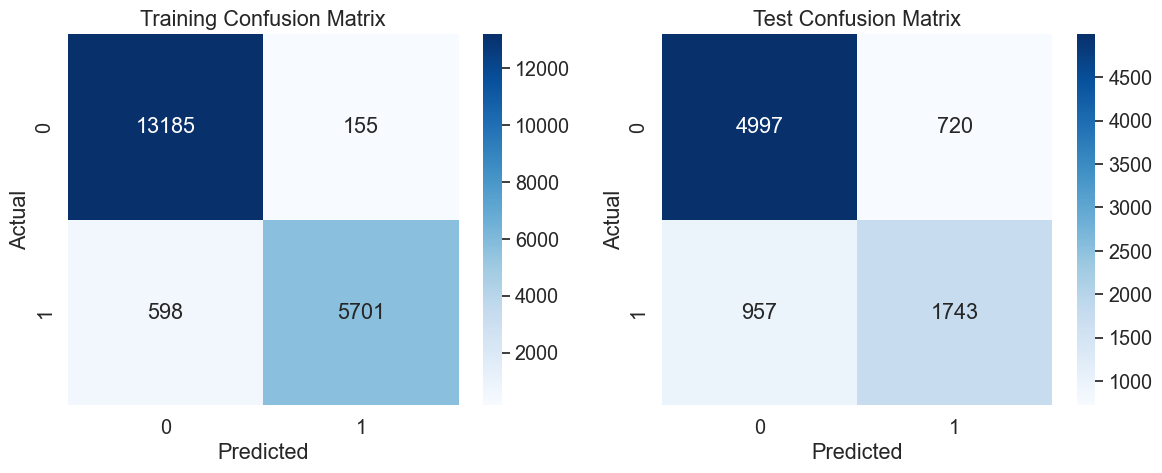

In [181]:
# XGBoost
model_xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
model_xgb.fit(X_train, y_train)
model_evaluation(model_xgb)

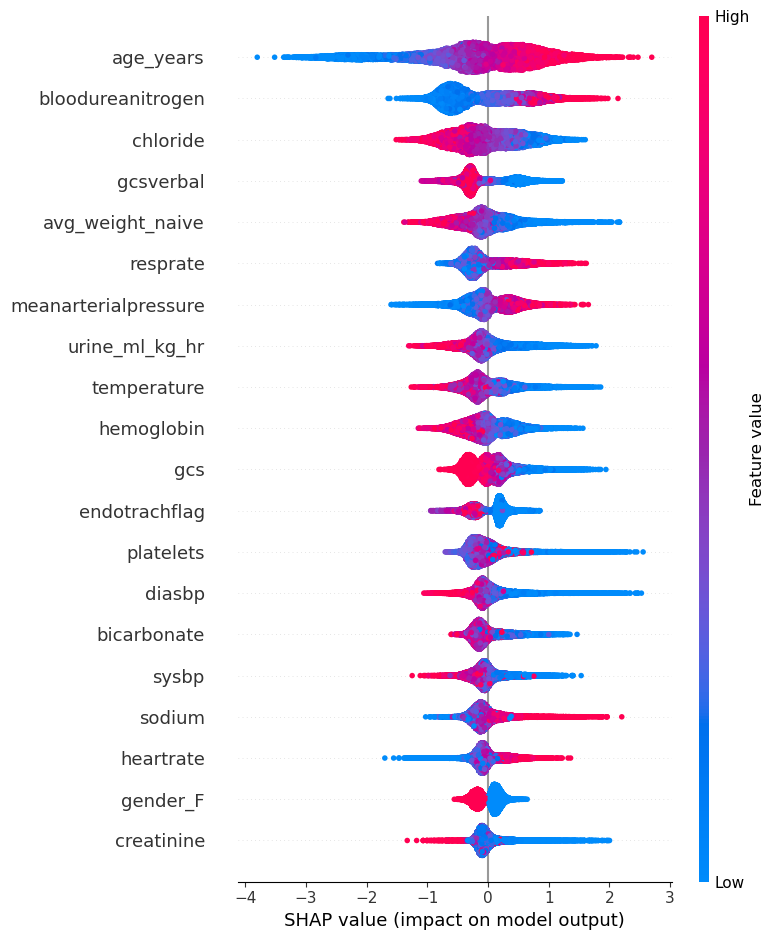

In [146]:
explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb.shap_values(X)

shap.summary_plot(shap_values_xgb, X)